If you are not using the `Assignments` tab on the course JupyterHub server to read this notebook, read [Activating the assignments tab](https://github.com/lcdm-uiuc/info490-sp17/blob/master/help/act_assign_tab.md).

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do **not** write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select _Kernel_, and restart the kernel and run all cells (_Restart & Run all_).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select _File_ → _Save and CheckPoint_)

5. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

## Problem 11.2. Hierarchical Modeling.

In this problem, we will implement a hierarchical model to estimate the distribution of departure delays in June of 2001.

![](./images/hierarchical_p2.png)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

from nose.tools import assert_equal, assert_true, assert_is_instance
from numpy.testing import assert_array_almost_equal, assert_almost_equal

We use the [airline on-time performance data](http://stat-computing.org/dataexpo/2009/). For simplicity, we limit our analysis to flights that departed from the Central Illinois Regional Airport in Bloomington [BMI](https://en.wikipedia.org/wiki/Central_Illinois_Regional_Airport) in June.

In [2]:
filename = '/home/data_scientist/data/2001.csv'

usecols = (1, 2, 15, 16)
columns = ['Month', 'DayofMonth', 'DepDelay', 'Origin']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)

local = all_data[
    (all_data['Origin'] == 'BMI') & # use only flights departed from Bloomington
    (all_data['Month'] == 6) # consider only June
    ]
local = local.drop(['Month', 'Origin'], axis=1) # we don't need Month and Origin columns
local = local.dropna() # drop missing values

print(local.head())

         DayofMonth  DepDelay
2938513           1      45.0
2938514           2      -3.0
2938515           3      -4.0
2938516           4       1.0
2938519           7      -2.0


We will use a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) (see the next section) but the Poisson distribution does not allow negative means. That is, $\mu > 0$ in

$$ Poisson(\mu) = P(x\mid\mu) = \frac{e^{-\mu}\mu^{x}}{x!}\quad\textrm{for}\, x=0,1,2,\cdots $$

However, there are some negative values in `DepDelay`.

In [3]:
print(local.DepDelay.min())

-10.0


This condition can be avoided by a simple shift in the domain, so let's add 10 minutes to all departure delays.

In [4]:
def shift_column(df, field, shift):
    return pd.concat([df.drop(field, axis=1), df[field].apply(lambda x: x + shift)], axis=1) 

local_shifted = shift_column(local, 'DepDelay', 10)

print(local_shifted.head())

         DayofMonth  DepDelay
2938513           1      55.0
2938514           2       7.0
2938515           3       6.0
2938516           4      11.0
2938519           7       8.0


The following code cell asserts that all values in `DepDelay` are non-negative.

In [5]:
assert_equal((local_shifted.DepDelay.values < 0).sum(), 0)

For simplicity, let's remove some outliers and only consider departure delays less than 60 minutes.

In [6]:
local_shifted = local_shifted[local_shifted['DepDelay'] < 60]
# check if there are any values greater than 60
assert_equal((local_shifted.DepDelay.values > 60).sum(), 0)

In the following section, we model each day independently, modeling paramters $\mu_i$ of the Poisson distribution for each day of June, $i=1, 2, \cdots, 30$. The reasoning behind this is that the departure delays will depend on different conditions of each day, e.g. the weather, whether it's a weekend or a weekday, whehter it's a holiday, etc.

Simiarly to the use of `county_idx` in [one of the required readings](https://pymc-devs.github.io/pymc3/notebooks/GLM-hierarchical.html), we need a way to map `mu` (an array of length 30) to an array that has the length as `local_shifted`. Read the required readings to see how `county_idx` is used [here](https://pymc-devs.github.io/pymc3/notebooks/GLM-hierarchical.html) and how `participants_idx` is used [here](http://nbviewer.jupyter.org/github/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%203.%20Hierarchical%20modelling.ipynb). 

We can use the `DayofMonth` column to create `date_idx`:

In [7]:
date_idx = local_shifted['DayofMonth'].values - 1
print(date_idx)

[ 0  1  2  3  6  7  8  9 10 12 13 15 16 17 18 19 21 22 23 24 25 26 27 28 29
  0  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 27 28
 29  0  2  3  5  6  7  9 10 11 12 14 16 17 18 19 21 23 24 25 26 27 28  0  1
  2  3  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]


And we can use `date_idx` as follows:

```python
>>> mu = np.arange(30)
>>> print(mu)
```
```
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
```
```python
>>> print(mu[date_idx])
```
```
[ 0  1  2  3  6  7  8  9 10 12 13 15 16 17 18 19 21 22 23 24 25 26 27 28 29
  0  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 27 28
 29  0  2  3  5  6  7  9 10 11 12 14 16 17 18 19 21 23 24 25 26 27 28  0  1
  2  3  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
```
```python
>>> len(mu[date_idx]) == len(local_shifted)
```
```
True
```

## Hierarchical Model

- Implement the following hierarchical model using `pymc3`:
$$
\begin{aligned}
y_{ji} &\sim Poisson(\mu_{i}) \\
\mu_i &= Gamma(\alpha_\mu, \beta_\mu) \\
\alpha_\mu &= Gamma(1, 1) \\
\beta_\mu &= Gamma(1, 1)
\end{aligned}
$$
for each flight $j$ and each day $i$.

  Note there are two ways to specify a [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution): either in terms of alpha and beta or mean and standard deviation. In this problem, we parametrize it in terms of alpha (the shape parameter) and beta (the rate parameter).

- Use the names `mu`, `hyper_alpha_mu`, and `hyper_beta_mu` for $\mu_i$, $\alpha_\mu$, and $\beta_\mu$, respectively.
- Estimate the model paramters with the maximum a posteriori (MAP) method.
- Use the `Metropolis` sampler to generate posterior samples.
- Use the `random_seed` parameter in `pymc3.sample()` method for reproducibility.
- Use the name `y_pred` for posterior predictive distribution.

In [19]:
def sample_posterior(X, idx, n_samples=2000, random_seed=0):
    '''
    A hierarchical Poisson model.
    
    Paramters
    ---------
    X: A numpy array
    idx: A numpy array
    n_samples: The number of samples to draw in pymc3.sample().
               Defaults to 2000.
    random_seed: An int. Used in pymc3.sample().
                 Defaults to 0.
                 
    Returns
    -------
    A pymc3.MultiTrace object with access to sampling values.
    '''
    
    # YOUR CODE HERE
    with pm.Model() as hierarchical_model:
        # Hyperpriors
        hyper_alpha_mu = pm.Gamma('hyper_alpha_mu', 1, 1)
        hyper_beta_mu = pm.Gamma('hyper_beta_mu', 1, 1)
        mu = pm.Gamma('mu', alpha = hyper_alpha_mu, beta = hyper_beta_mu, shape = 30)
        
        y_est = pm.Poisson('y_est', mu = mu[idx], observed = X)
        y_pred = pm.Poisson('y_pred', mu = mu[idx], shape = len(local_shifted))
    
    # Compute the hierarhical model likelihood and generate sample points.
    with hierarchical_model:
        start = pm.find_MAP()
        step = pm.Metropolis() # sampler
        trace = pm.sample(n_samples, step, start = start, 
                          progressbar = True, random_seed = random_seed)
 
    return trace

In [21]:
hierarchical_trace = sample_posterior(X=local_shifted['DepDelay'].values, idx=date_idx, n_samples=50000, random_seed=0)

Optimization terminated successfully.
         Current function value: 1084.438757
         Iterations: 44
         Function evaluations: 60
         Gradient evaluations: 60


100%|██████████| 50000/50000 [00:30<00:00, 1643.96it/s]


## Tests

In [22]:
assert_is_instance(hierarchical_trace, pm.backends.base.MultiTrace)

In [23]:
assert_true('mu' in hierarchical_trace.varnames)
assert_true('hyper_alpha_mu' in hierarchical_trace.varnames)
assert_true('hyper_beta_mu' in hierarchical_trace.varnames)

In [24]:
for v in hierarchical_trace.varnames:
    assert_equal(len(hierarchical_trace[v]), 50000)
    
assert_equal(hierarchical_trace['mu'].shape[1], 30)

In [25]:
# note the length of array is 30 for 30 days in the month
assert_array_almost_equal(
    hierarchical_trace['mu'][0],
    [  8.93494936,   4.0622874,    4.14991769,   7.88457657,   6.25999938,
      21.24216992,   3.9165015,    4.61675007,   4.50005472,   3.33296105,
      10.2187384,    3.40560029,   7.5344523,    5.41352113,   9.67636418,
       5.71800992,   5.31699857,  10.80227888,   3.56637722,   3.33296102,
       4.71897438,   2.98283677,  11.96003013,   3.33296105,   3.68308532,
       7.65116039,   4.04332153,   4.85016623,   3.44966913,   8.00167584]
   )
assert_almost_equal(hierarchical_trace['hyper_alpha_mu'][0], 3.5580976444411982,3)
assert_almost_equal(hierarchical_trace['hyper_beta_mu'][0], 0.56838626066539077,3)

In [26]:
assert_array_almost_equal(
    hierarchical_trace['mu'][-1],
    [ 19.77166963,   6.14628482,   6.8238745,   15.03404489,   5.60213034,
      44.56764984,   6.07092499,   7.68898026,   7.70654923,   6.26091794,
      21.36239315,   4.81410598,  14.12608149,   9.66526395,  19.80288854,
      11.97265248,  13.66763089,  20.10743819,   8.36165972,   3.53264275,
       9.1774443,    3.60443517,  26.20173204,   4.84636078,   4.99342565,
      14.87326008,   6.77082538,   9.67180886,   8.07633971,  13.53228736]
     )
assert_array_almost_equal(
    hierarchical_trace['hyper_alpha_mu'][-5:],
    [ 2.72175 ,  2.72175 ,  2.72175 ,  2.533818,  2.533818]
    )
assert_array_almost_equal(
    hierarchical_trace['hyper_beta_mu'][-5:],
    [ 0.243719,  0.237223,  0.237223,  0.237223,  0.206227]
)

## Model Checking

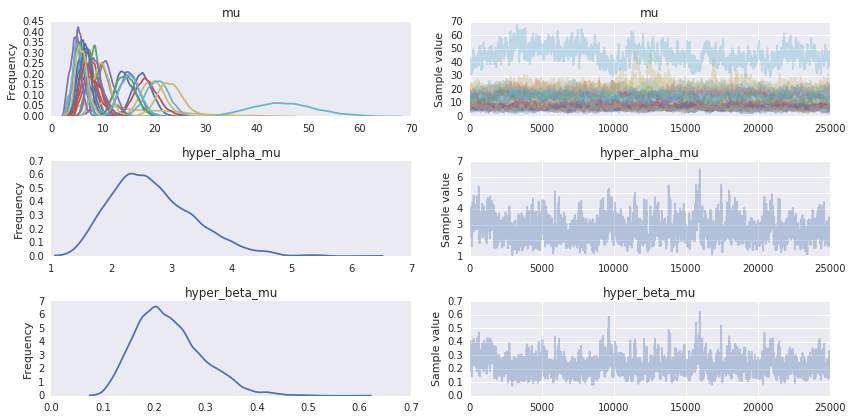

In [27]:
pm.traceplot(hierarchical_trace[25000:], varnames=['mu', 'hyper_alpha_mu', 'hyper_beta_mu']);

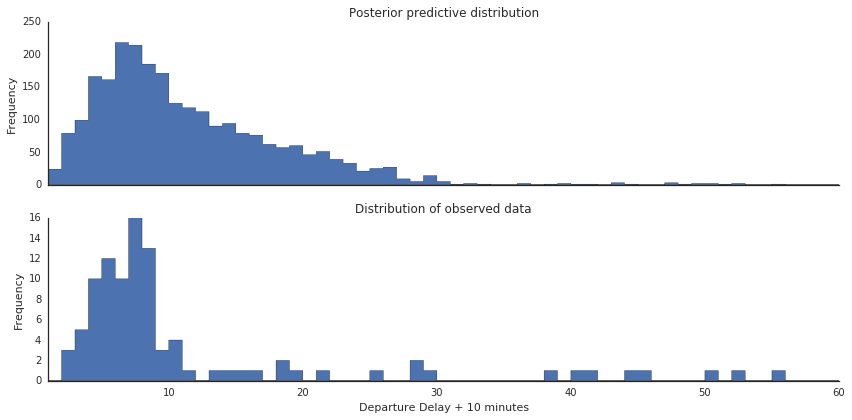

In [28]:
x_lim = 60
n_burn = 25000

# we discard burn-in and use every 1000th trace
y_pred = hierarchical_trace.get_values('y_pred')[n_burn::1000].ravel()

sns.set_style('white')
fig, ax = plt.subplots(2, sharex=True, figsize=(12,6))

ax[0].hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled')   
ax[0].set_xlim(1, x_lim)
ax[0].set_ylabel('Frequency')
ax[0].set_title('Posterior predictive distribution')

ax[1].hist(local_shifted.DepDelay.values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
ax[1].set_xlabel('Departure Delay + 10 minutes')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of observed data')

sns.despine()

plt.tight_layout()
plt.show()